# American Community Survey - California - 2017 Analysis

In this notebook, I will practice conducting statistical tests and visualizing data within Python. 

The data I'm using comes from the 2017 American Community Survey. I am looking at data from the 15 most populous counties in California only. The table I am using is "Selected Characteristics of People at Specified Levels of Poverty in the Past 12 Months." This will allow us to see how poverty levels differ in different counties of California and among different populations.

The structure of this notebook is as follows:
* **Data Preparation** 
  * **Poverty by County**
  * **Poverty by Sex**
  * **Poverty by Disability**
* **Data Analysis and Visualization** 
  * **Poverty by County**
    * *Which counties are the most populous?*
    * *Which counties have the highest rates of poverty?*
    * *Do coastal or inland counties have higher rates of poverty, on average?*
    * *Are these differences statistically significant?*
  * **Poverty by Sex**
    * *Do males or females have higher rates of poverty, on average?*
    * *Are these differences statistically significant?*
  * **Poverty by Disability**
    * *Which counties have the highest rates of disability?*
    * *Which counties have the highest rates of poverty among the disabled?*
    * *Do disabled people have similar rates of poverty across different counties?*
* **Summary**

In [159]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

## Data Preparation

Let's import and clean up the data.

In [160]:
raw_data = pd.read_csv('ACS_17_1YR_S1703_with_ann.csv')
metadata = pd.read_csv('ACS_17_1YR_S1703_metadata.csv')

In [161]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Columns: 283 entries, GEO.id to HC04_MOE_VC51
dtypes: object(283)
memory usage: 35.5+ KB


In [162]:
raw_data.head(5)

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC50,HC04_MOE_VC50,HC01_EST_VC51,HC01_MOE_VC51,HC02_EST_VC51,HC02_MOE_VC51,HC03_EST_VC51,HC03_MOE_VC51,HC04_EST_VC51,HC04_MOE_VC51
0,Id,Id2,Geography,Total; Estimate; Population for whom poverty s...,Total; Margin of Error; Population for whom po...,Less than 50 percent of the poverty level; Est...,Less than 50 percent of the poverty level; Mar...,Less than 100 percent of the poverty level; Es...,Less than 100 percent of the poverty level; Ma...,Less than 125 percent of the poverty level; Es...,...,Less than 125 percent of the poverty level; Es...,Less than 125 percent of the poverty level; Ma...,Total; Estimate; WORK STATUS - Population 16 t...,Total; Margin of Error; WORK STATUS - Populati...,Less than 50 percent of the poverty level; Est...,Less than 50 percent of the poverty level; Mar...,Less than 100 percent of the poverty level; Es...,Less than 100 percent of the poverty level; Ma...,Less than 125 percent of the poverty level; Es...,Less than 125 percent of the poverty level; Ma...
1,0500000US06001,06001,"Alameda County, California",1636780,2648,4.4,0.4,9.2,0.5,12.1,...,17.1,1.5,231484,7735,14.8,1.5,24.6,1.5,29.2,1.6
2,0500000US06013,06013,"Contra Costa County, California",1138850,1328,4.2,0.6,9.3,0.9,12.4,...,14.1,1.7,168044,7131,13.6,1.9,22.6,2.8,28.2,3.0
3,0500000US06019,06019,"Fresno County, California",972580,1778,9.0,0.9,21.1,1.3,27.9,...,32.9,2.5,177421,6349,19.1,2.3,36.6,2.4,43.9,2.5
4,0500000US06029,06029,"Kern County, California",860951,2581,9.8,1.0,21.4,1.6,28.9,...,29.6,3.0,179140,7436,19.4,2.3,35.5,3.0,44.9,3.2


Our file has nonintuitive column names and a descriptor row. This is a problem because Pandas is storing every column as an object, since every column has a string value. 

We could write some code to fix that here in our notebook, but it will be faster to save a DataFrame without the string descriptor row to our computer and then reimport it, so Pandas can automatically read it correctly. 

While we're at it, let's change the county names to be shorter so we don't have to keep manually doing this later on.

In [163]:
fixed_data = raw_data[raw_data['GEO.id2'] != 'Id2'].reset_index()
fixed_data['GEO.display-label'] = fixed_data['GEO.display-label'].apply(lambda x: x.split(' County')[0])
fixed_data.to_csv('ACS_17_1YR_S1703_FIXED.csv')
data = pd.read_csv('ACS_17_1YR_S1703_FIXED.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Columns: 285 entries, Unnamed: 0 to HC04_MOE_VC51
dtypes: float64(210), int64(73), object(2)
memory usage: 33.5+ KB


,Unnamed: 0,index,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,...,HC04_EST_VC50,HC04_MOE_VC50,HC01_EST_VC51,HC01_MOE_VC51,HC02_EST_VC51,HC02_MOE_VC51,HC03_EST_VC51,HC03_MOE_VC51,HC04_EST_VC51,HC04_MOE_VC51
0,0,1,0500000US06001,6001,Alameda,1636780,2648,4.4,0.4,9.2,...,17.1,1.5,231484,7735,14.8,1.5,24.6,1.5,29.2,1.6
1,1,2,0500000US06013,6013,Contra Costa,1138850,1328,4.2,0.6,9.3,...,14.1,1.7,168044,7131,13.6,1.9,22.6,2.8,28.2,3.0
2,2,3,0500000US06019,6019,Fresno,972580,1778,9.0,0.9,21.1,...,32.9,2.5,177421,6349,19.1,2.3,36.6,2.4,43.9,2.5
3,3,4,0500000US06029,6029,Kern,860951,2581,9.8,1.0,21.4,...,29.6,3.0,179140,7436,19.4,2.3,35.5,3.0,44.9,3.2
4,4,5,0500000US06037,6037,Los Angeles,10015695,5187,6.1,0.2,14.9,...,21.3,0.6,1713389,17864,17.3,0.7,30.6,0.8,37.3,0.8


Fixed! Let's move on.

This is a very large file with many variables. We only want to analyze poverty by county, sex, and disability. Let's separate our DataFrame into smaller DataFrames with descriptive column names to make our analysis easier. 

### Poverty by County

In [164]:
data_county = data[['GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'HC01_MOE_VC01', 'HC02_EST_VC01', 'HC02_MOE_VC01', 'HC03_EST_VC01', 'HC03_MOE_VC01', 'HC04_EST_VC01', 'HC04_MOE_VC01']]
data_county.columns = ['county_id', 'county', 'county_population', 'county_population_error', 'county_50_poverty', 'county_50_poverty_error', 'county_100_poverty', 'county_100_poverty_error', 'county_125_poverty', 'county_125_poverty_error']
data_county

,county_id,county,county_population,county_population_error,county_50_poverty,county_50_poverty_error,county_100_poverty,county_100_poverty_error,county_125_poverty,county_125_poverty_error
0,6001,Alameda,1636780,2648,4.4,0.4,9.2,0.5,12.1,0.7
1,6013,Contra Costa,1138850,1328,4.2,0.6,9.3,0.9,12.4,1.1
2,6019,Fresno,972580,1778,9.0,0.9,21.1,1.3,27.9,1.5
3,6029,Kern,860951,2581,9.8,1.0,21.4,1.6,28.9,1.8
4,6037,Los Angeles,10015695,5187,6.1,0.2,14.9,0.3,20.0,0.4
5,6059,Orange,3154479,3139,4.9,0.3,11.5,0.5,15.3,0.6
6,6065,Riverside,2385745,4745,6.0,0.5,12.9,0.7,17.8,0.9
7,6067,Sacramento,1509927,2925,5.9,0.6,14.1,0.8,19.3,1.0
8,6071,San Bernardino,2093857,5512,6.8,0.5,16.2,0.8,21.7,1.0
9,6073,San Diego,3256674,4245,5.4,0.4,11.8,0.6,15.6,0.7


### Poverty by Sex

In [165]:
data_sex = data[['GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'HC01_EST_VC03', 'HC01_MOE_VC03', 'HC02_EST_VC03', 'HC02_MOE_VC03', 'HC03_EST_VC03', 'HC03_MOE_VC03', 'HC04_EST_VC03', 'HC04_MOE_VC03', 'HC01_EST_VC04', 'HC01_MOE_VC04', 'HC02_EST_VC04', 'HC02_MOE_VC04', 'HC03_EST_VC04', 'HC03_MOE_VC04', 'HC04_EST_VC04', 'HC04_MOE_VC04']]
data_sex.columns = ['county_id', 'county', 'county_population', 'male_population', 'male_population_error', 'male_50_poverty', 'male_50_poverty_error', 'male_100_poverty', 'male_100_poverty_error', 'male_125_poverty', 'male_125_poverty_error', 'female_population', 'female_population_error', 'female_50_poverty', 'female_50_poverty_error', 'female_100_poverty', 'female_100_poverty_error', 'female_125_poverty', 'female_125_poverty_error']
data_sex

,county_id,county,county_population,male_population,male_population_error,male_50_poverty,male_50_poverty_error,male_100_poverty,male_100_poverty_error,male_125_poverty,male_125_poverty_error,female_population,female_population_error,female_50_poverty,female_50_poverty_error,female_100_poverty,female_100_poverty_error,female_125_poverty,female_125_poverty_error
0,6001,Alameda,1636780,805980,1611,3.8,0.5,8.1,0.5,11.0,0.7,830800,1839,5.0,0.5,10.3,0.7,13.3,0.8
1,6013,Contra Costa,1138850,556457,1047,3.6,0.6,8.4,0.8,11.4,1.1,582393,975,4.7,0.7,10.1,1.2,13.4,1.3
2,6019,Fresno,972580,482307,1542,7.8,1.0,19.5,1.4,26.4,1.7,490273,1401,10.2,1.1,22.7,1.5,29.3,1.5
3,6029,Kern,860951,429554,2204,9.1,1.2,19.6,1.7,26.8,1.9,431397,1219,10.5,1.2,23.3,1.9,31.0,2.1
4,6037,Los Angeles,10015695,4932694,3676,5.5,0.3,13.7,0.3,18.7,0.4,5083001,3454,6.7,0.3,16.0,0.4,21.3,0.4
5,6059,Orange,3154479,1557292,2183,4.5,0.4,10.5,0.6,14.2,0.7,1597187,1981,5.3,0.4,12.4,0.6,16.4,0.6
6,6065,Riverside,2385745,1183107,2722,5.0,0.4,11.1,0.7,15.7,0.9,1202638,3627,6.9,0.6,14.6,0.8,19.9,1.0
7,6067,Sacramento,1509927,734664,2227,5.7,0.6,13.9,1.0,18.9,1.2,775263,1893,6.1,0.7,14.3,1.0,19.7,1.1
8,6071,San Bernardino,2093857,1025156,4020,6.1,0.6,14.8,1.0,20.0,1.2,1068701,4017,7.4,0.6,17.4,0.9,23.3,1.0
9,6073,San Diego,3256674,1621988,3295,5.1,0.5,11.1,0.6,14.7,0.8,1634686,3066,5.8,0.5,12.6,0.7,16.6,0.7


### Poverty by Disability

In [166]:
data_disability = data[['GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'HC01_EST_VC44', 'HC01_MOE_VC44', 'HC02_EST_VC44', 'HC02_MOE_VC44', 'HC03_EST_VC44', 'HC03_MOE_VC44', 'HC04_EST_VC44', 'HC04_MOE_VC44']]
data_disability.columns = ['county_id', 'county', 'county_population', 'disabled_population', 'disabled_population_error', 'disabled_50_poverty', 'disabled_50_poverty_error', 'disabled_100_poverty', 'disabled_100_poverty_error', 'disabled_125_poverty', 'disabled_125_poverty_error']
data_disability

,county_id,county,county_population,disabled_population,disabled_population_error,disabled_50_poverty,disabled_50_poverty_error,disabled_100_poverty,disabled_100_poverty_error,disabled_125_poverty,disabled_125_poverty_error
0,6001,Alameda,1636780,149018,5505,6.3,1.1,19.0,1.8,24.3,1.9
1,6013,Contra Costa,1138850,132811,6251,7.6,1.8,16.4,2.5,20.7,2.7
2,6019,Fresno,972580,141769,6634,9.3,1.6,25.5,2.3,33.8,2.6
3,6029,Kern,860951,100767,5662,13.2,2.3,29.3,3.2,37.3,3.4
4,6037,Los Angeles,10015695,984672,15616,7.3,0.5,20.9,0.7,28.5,0.8
5,6059,Orange,3154479,272245,7216,5.8,0.7,14.4,1.3,20.2,1.4
6,6065,Riverside,2385745,280885,10078,7.4,0.9,17.4,1.5,23.0,1.6
7,6067,Sacramento,1509927,177711,7531,7.4,1.0,19.2,1.5,25.2,1.6
8,6071,San Bernardino,2093857,241906,7532,7.4,1.2,19.6,1.8,25.8,1.9
9,6073,San Diego,3256674,309681,9591,6.1,0.8,15.7,1.2,20.9,1.3


## Analysis and Visualization

Let's begin analyzing and visualizing our data.

### Poverty by County

**Which counties are the most populous?**

We can start by visualizing the total population sizes of the 15 California counties included in our dataset. We'll do this with pyplot from Matplotlib and with Seaborn to practice using both libraries. 

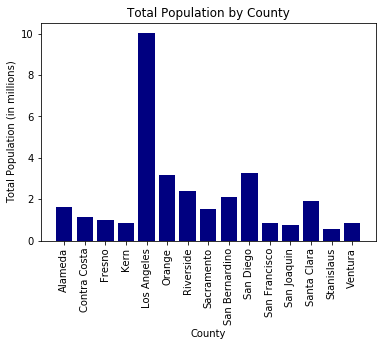

In [200]:
county_x_values = range(len(data_county.county_population))

ax = plt.subplot()

plt.bar(county_x_values, data_county.county_population, color = 'navy')

plt.xlabel('County')
plt.ylabel('Total Population (in millions)')
plt.title('Total Population by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)
ax.set_yticks([0, 2000000, 4000000, 6000000, 8000000, 10000000])
ax.set_yticklabels([0, 2, 4, 6, 8, 10])


plt.show()

We'll produce the same graph using Seaborn.

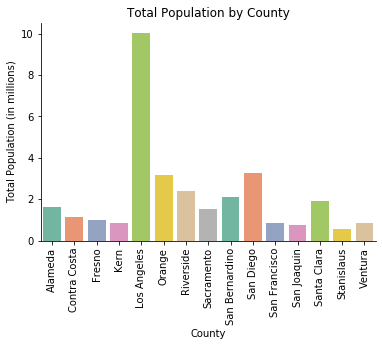

In [199]:
ax = plt.subplot()

sns.barplot(data = data_county, x = 'county', y = 'county_population', palette = 'Set2')

plt.xlabel('County')
plt.ylabel('Total Population (in millions)')
plt.title('Total Population by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)
ax.set_yticks([0, 2000000, 4000000, 6000000, 8000000, 10000000])
ax.set_yticklabels([0, 2, 4, 6, 8, 10])

sns.despine()



plt.show()

**Which counties have the highest rates of poverty?**

Now let's see the poverty levels in each county. Our ACS dataset already includes the percentage of individuals in each poverty level, which makes it easy to compare poverty levels for counties with different population sizes. 

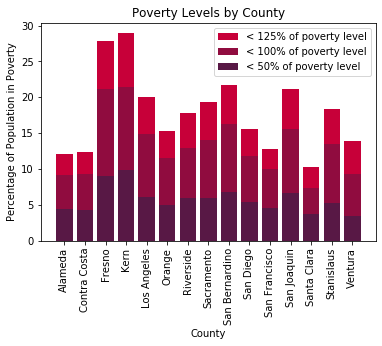

In [169]:
ax = plt.subplot()

plt.bar(county_x_values, data_county.county_125_poverty, color = '#C70039')
plt.bar(county_x_values, data_county.county_100_poverty, color = '#900C3F')
plt.bar(county_x_values, data_county.county_50_poverty, color = '#581845')

plt.legend(['< 125% of poverty level','< 100% of poverty level','< 50% of poverty level'])

plt.xlabel('County')
plt.ylabel('Percentage of Population in Poverty')
plt.title('Poverty Levels by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)

plt.show()

We can see that Kern and Fresno counties have the highest rates of poverty, while Santa Clara, Alameda, and Contra Costa have the lowest rates. 

Why is this the case? Let's investigate if the location of counties impacts their poverty levels.

**Do coastal or inland counties have higher rates of poverty, on average?**

We'll start by assigning each county to either an "inland" or "coastal" label. 

(Python will throw us a warning because we're editing the county copy of our main DataFrame and not the original DataFrame itself. This is fine; we're only going to be analyzing the location in relation to the county. We could add this column to our main DataFrame in the future if we wanted to run different analyses but I won't waste time on it now.)

In [170]:
data_county['location'] = ['coastal', 'coastal', 'inland', 'inland', 'coastal', 'coastal', 'inland', 'inland', 'inland', 'coastal', 'coastal', 'inland', 'coastal', 'inland', 'coastal']

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We will eventually run a chi-square test to see if there is a statistically significant difference in poverty levels between the 15 most populous inland and coastal counties of California. First, let's see if there is an obvious difference in poverty levels between the two locations.

In [171]:
poverty_by_location = data_county[['county', 'location', 'county_125_poverty']]
poverty_by_location

,county,location,county_125_poverty
0,Alameda,coastal,12.1
1,Contra Costa,coastal,12.4
2,Fresno,inland,27.9
3,Kern,inland,28.9
4,Los Angeles,coastal,20.0
5,Orange,coastal,15.3
6,Riverside,inland,17.8
7,Sacramento,inland,19.3
8,San Bernardino,inland,21.7
9,San Diego,coastal,15.6


In [172]:
poverty_by_location_grouped = poverty_by_location.groupby('location').county_125_poverty.mean().reset_index()
poverty_by_location_grouped

,location,county_125_poverty
0,coastal,14.037500
1,inland,22.157143


It looks like the populous inland counties have a higher rate of poverty, on average. 

**Are these differences statistically significant?**

Now let's run our chi-square test. This will be a little time consuming because we must find the *number* of people in poverty in each county, not the *percentage*. We also need to find the number of people *not* in poverty. We can find this by multiplying the percentages by the county population size.

(We'll get a warning again; we're not trying to edit our original DataFrame, just run some analyses in place on our copy, so this is fine.)

In [173]:
poverty_by_location = data_county[['county', 'location', 'county_125_poverty', 'county_population']]
poverty_by_location['number_poverty'] = poverty_by_location.county_population * poverty_by_location.county_125_poverty / 100
poverty_by_location['number_not_poverty'] = poverty_by_location.county_population - poverty_by_location.number_poverty
poverty_by_location

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,county,location,county_125_poverty,county_population,number_poverty,number_not_poverty
0,Alameda,coastal,12.1,1636780,198050.380,1438729.620
1,Contra Costa,coastal,12.4,1138850,141217.400,997632.600
2,Fresno,inland,27.9,972580,271349.820,701230.180
3,Kern,inland,28.9,860951,248814.839,612136.161
4,Los Angeles,coastal,20.0,10015695,2003139.000,8012556.000
5,Orange,coastal,15.3,3154479,482635.287,2671843.713
6,Riverside,inland,17.8,2385745,424662.610,1961082.390
7,Sacramento,inland,19.3,1509927,291415.911,1218511.089
8,San Bernardino,inland,21.7,2093857,454366.969,1639490.031
9,San Diego,coastal,15.6,3256674,508041.144,2748632.856


Let's group these results so we can plug them into our chi-square test.

In [174]:
poverty_by_location_grouped2 = poverty_by_location.groupby('location')['number_poverty', 'number_not_poverty'].sum().reset_index()
poverty_by_location_grouped2

,location,number_poverty,number_not_poverty
0,coastal,3756226.934,1.906726e+07
1,inland,1944706.948,7.152156e+06


Now let's run our chi-square test!

In [175]:
location_table = [[3756227, 1944707],
                  [19067260, 7152156]]

total_population = 0

for list in location_table:
    for i in list:
        total_population += i

chi2, pval, dof, expected = chi2_contingency(location_table)

print(chi2, pval, dof)
print(total_population)

107327.22932763721 0.0 1
31920350


We have such a large chi-square value and such a small p-value because our sample size is so large. This is to be expected; when working with Census data, even the smallest patterns tend to come up significant, and this pattern is quite a prominent one. 

We can interpret the results of our test as follows.

There is a significant difference in poverty levels between populous inland and populous coastal counties in California. Populous inland counties have higher rates of poverty, on average. χ²(1, N = 31,930,350) = 107327.23, p < 0.001. 

### Poverty by Sex

**Do males or females have higher rates of poverty, on average?**

We want to see if there significant differences in poverty levels between males and females in the most populous counties of California.

We can start by visualizing our relevant data to see if any obvious patterns emerge.

First, let's graph gender differences in poverty levels for each county. Later we will combine our data to visualize overall gender differences within our whole dataset. 

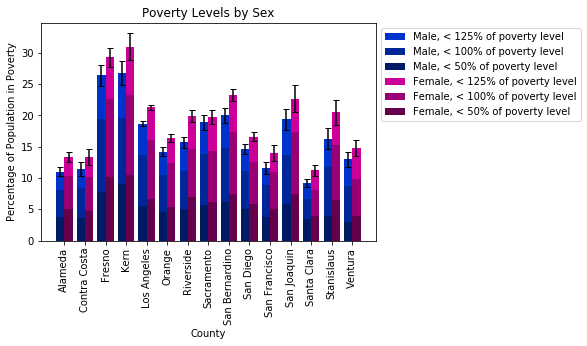

In [176]:
def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

sex_x_values1 = create_x(2, 0.8, 1, 15)
sex_x_values2 = create_x(2, 0.8, 2, 15)

sex_middle_x = [(a + b) / 2.0 for a, b in zip(sex_x_values1, sex_x_values2)]

ax = plt.subplot()

plt.bar(sex_x_values1, data_sex.male_125_poverty, yerr = data_sex.male_125_poverty_error, capsize = 3, color = '#0033cc', label = 'Male, < 125% of poverty level')
plt.bar(sex_x_values1, data_sex.male_100_poverty, color = '#002699', label = 'Male, < 100% of poverty level')
plt.bar(sex_x_values1, data_sex.male_50_poverty, color = '#001a66', label = 'Male, < 50% of poverty level')

plt.bar(sex_x_values2, data_sex.female_125_poverty, yerr = data_sex.female_125_poverty_error, capsize = 3, color = '#cc0099', label = 'Female, < 125% of poverty level')
plt.bar(sex_x_values2, data_sex.female_100_poverty, color = '#990073', label = 'Female, < 100% of poverty level')
plt.bar(sex_x_values2, data_sex.female_50_poverty, color = '#66004d', label = 'Female, < 50% of poverty level')

plt.legend(bbox_to_anchor = (1.0, 1.0))

plt.xlabel('County')
plt.ylabel('Percentage of Population in Poverty')
plt.title('Poverty Levels by Sex')

ax.set_xticks(sex_middle_x)
ax.set_xticklabels(data_county.county, rotation = 90)





plt.show()

It looks like females have higher rates of poverty in every populous county in California.

**Are these differences statistically significant?**

Let's run a chi-square test to see if the gender differences in our graph are significant.

Again, we'll need to calculate the number of women and men in poverty (and not in poverty) for our whole dataset.

In [177]:
poverty_by_sex = data_sex[['county', 'male_population', 'male_125_poverty', 'female_population', 'female_125_poverty']]
poverty_by_sex['number_male_poverty'] = poverty_by_sex.male_population * poverty_by_sex.male_125_poverty / 100
poverty_by_sex['number_male_not_poverty'] = poverty_by_sex.male_population - poverty_by_sex.number_male_poverty
poverty_by_sex['number_female_poverty'] = poverty_by_sex.female_population * poverty_by_sex.female_125_poverty / 100
poverty_by_sex['number_female_not_poverty'] = poverty_by_sex.female_population - poverty_by_sex.number_female_poverty
poverty_by_sex

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,county,male_population,male_125_poverty,female_population,female_125_poverty,number_male_poverty,number_male_not_poverty,number_female_poverty,number_female_not_poverty
0,Alameda,805980,11.0,830800,13.3,88657.800,717322.200,110496.400,720303.600
1,Contra Costa,556457,11.4,582393,13.4,63436.098,493020.902,78040.662,504352.338
2,Fresno,482307,26.4,490273,29.3,127329.048,354977.952,143649.989,346623.011
3,Kern,429554,26.8,431397,31.0,115120.472,314433.528,133733.070,297663.930
4,Los Angeles,4932694,18.7,5083001,21.3,922413.778,4010280.222,1082679.213,4000321.787
5,Orange,1557292,14.2,1597187,16.4,221135.464,1336156.536,261938.668,1335248.332
6,Riverside,1183107,15.7,1202638,19.9,185747.799,997359.201,239324.962,963313.038
7,Sacramento,734664,18.9,775263,19.7,138851.496,595812.504,152726.811,622536.189
8,San Bernardino,1025156,20.0,1068701,23.3,205031.200,820124.800,249007.333,819693.667
9,San Diego,1621988,14.7,1634686,16.6,238432.236,1383555.764,271357.876,1363328.124


Let's make a small table that better displays these results so we can plug them into our chi-square test.

In [178]:
sex_results =  pd.DataFrame({'sex': ['male', 'female'], 'number_poverty': [poverty_by_sex.number_male_poverty.sum(), poverty_by_sex.number_female_poverty.sum()], 'number_not_poverty': [poverty_by_sex.number_male_not_poverty.sum(), poverty_by_sex.number_female_not_poverty.sum()]})

sex_results

,sex,number_poverty,number_not_poverty
0,male,2614216.815,1.316864e+07
1,female,3091713.456,1.304578e+07


In [179]:
sex_table = [[2614217, 13168640],
             [3091713, 13045780]]

total_sex_population = 0

for list in sex_table:
    for i in list:
        total_sex_population += i

chi2, pval, dof, expected = chi2_contingency(sex_table)

print(chi2, pval, dof)
print(total_sex_population)

36598.991849867496 0.0 1
31920350


We can interpret the results of our test as follows.

There is a significant difference in poverty levels between males and females within the 15 most populous counties of California. Females have higher rates of poverty, on average. χ²(1, N = 31,930,350) = 36598.99, p < 0.001. 

### Poverty by Disability

**Which counties have the highest rates of disability?**

Finally, let's examine if disability status impacts poverty levels.

We can start by visualizing the percentage of disabled people in each county in our dataset.

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


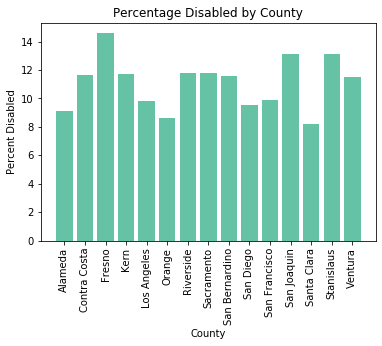

In [180]:
data_disability['disabled_percent'] = 100 * (data_disability.disabled_population / data_disability.county_population)

disability_x_values = range(len(data_disability.disabled_percent))

ax = plt.subplot()

plt.bar(disability_x_values, data_disability.disabled_percent)

plt.xlabel('County')
plt.ylabel('Percent Disabled')
plt.title('Percentage Disabled by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)


plt.show()

It looks like Fresno County has the highest rate of disability. In contrast, Santa Clara, Orange, and Alameda counties all have relatively low rates of disability. 

**Which counties have the highest rates of poverty among the disabled?**

This already seems to closely match our earlier visualization of poverty by county. It seems likely that disabled people are more likely to be in poverty, and thus counties with more disabled people are more likely to have higher poverty levels. 

We can investigate this hypothesis by examining the percentage of disabled people who are in poverty for each county. It could be that some counties have better resources for disabled people, and thus could have low poverty rates among the disabled. In order to examine this, we need to find the percentage of each county's population that is disabled *and* in poverty, instead of the percentage of the disabled population that is in poverty.

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


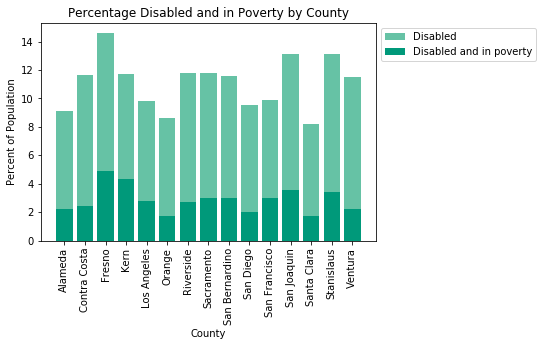

In [181]:
data_disability['disabled_poverty_percent'] = ((data_disability.disabled_125_poverty * data_disability.disabled_population) / data_disability.county_population)

disability_x_values = range(len(data_disability.disabled_percent))

ax = plt.subplot()

plt.bar(disability_x_values, data_disability.disabled_percent)
plt.bar(disability_x_values, data_disability.disabled_poverty_percent, color = '#00997a')

plt.xlabel('County')
plt.ylabel('Percent of Population')
plt.title('Percentage Disabled and in Poverty by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)

plt.legend(['Disabled','Disabled and in poverty'], bbox_to_anchor = (1.0, 1.0))

plt.show()

Overall, it looks like there is a fairly stable relationship between disability and poverty level throughout the populous counties of California. However, it does appear that some counties may have some variations in their disabled poverty levels. Contra Costa County and Ventura County both have higher rates of disability than Alameda, yet their rates of poverty among the disabled are about the same. 

**Do disabled people have similar rates of poverty across different counties?**

Let's examine this more closely by looking at the ratio of the percentage of disabled people in poverty to the percentage of all disabled people in each county.

In [182]:
data_disability['ratio'] = data_disability.disabled_poverty_percent / data_disability.disabled_percent 
data_disability[['county', 'ratio']]

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,county,ratio
0,Alameda,0.243
1,Contra Costa,0.207
2,Fresno,0.338
3,Kern,0.373
4,Los Angeles,0.285
5,Orange,0.202
6,Riverside,0.230
7,Sacramento,0.252
8,San Bernardino,0.258
9,San Diego,0.209


We can now clearly see variations in the ratio. As we saw in the visualization, Ventura and Contra Costa Counties have lower ratios (along with Orange County), while Fresno has the highest ratio. This means that, regardless of the size of the disabled population, Ventura's disabled residents are the least likely to be low-income out of the 15 most populous California counties, while Fresno's disabled residents are the most likely to be low-income.

Because our data file only contains aggregate statistics, and thus we do not know what our distributions look like for each county, it is difficult to determine which counties are significantly different in their disabled poverty levels from the California average. In the future, I could select a different ACS data file to examine these differences more closely, or I could spend some time developing a function to calculate the standard deviation of my calculated ratios given the margin of error for the supplied percentages. 

## Summary

We have learned the following from our brief exploration into the 2017 American Survey low-income data for the 15 most populous counties in California:
* Poverty is unevenly distributed in California counties
* Inland regions have significantly higher rates of poverty than coastal regions (p < .001)
* Females have significantly higher rates of poverty than males (p < .001)
* While disability seems to be related to poverty, disabled people can be more or less likely to be in poverty depending on which county they live in; disabled people in Fresno have the highest rates of poverty, while disabled people in Ventura have the lowest rates of poverty